## **1.2 $\texttt{P-VAE Synth}$ testing**

Experiments regarding the $\texttt{P-VAE Synth}$.

In [1]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [2]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [3]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.time_stamps           as ts
import ddsp_textures.architectures.VAE               as VAE

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import itertools

### Experiment 1: Time stamps generator

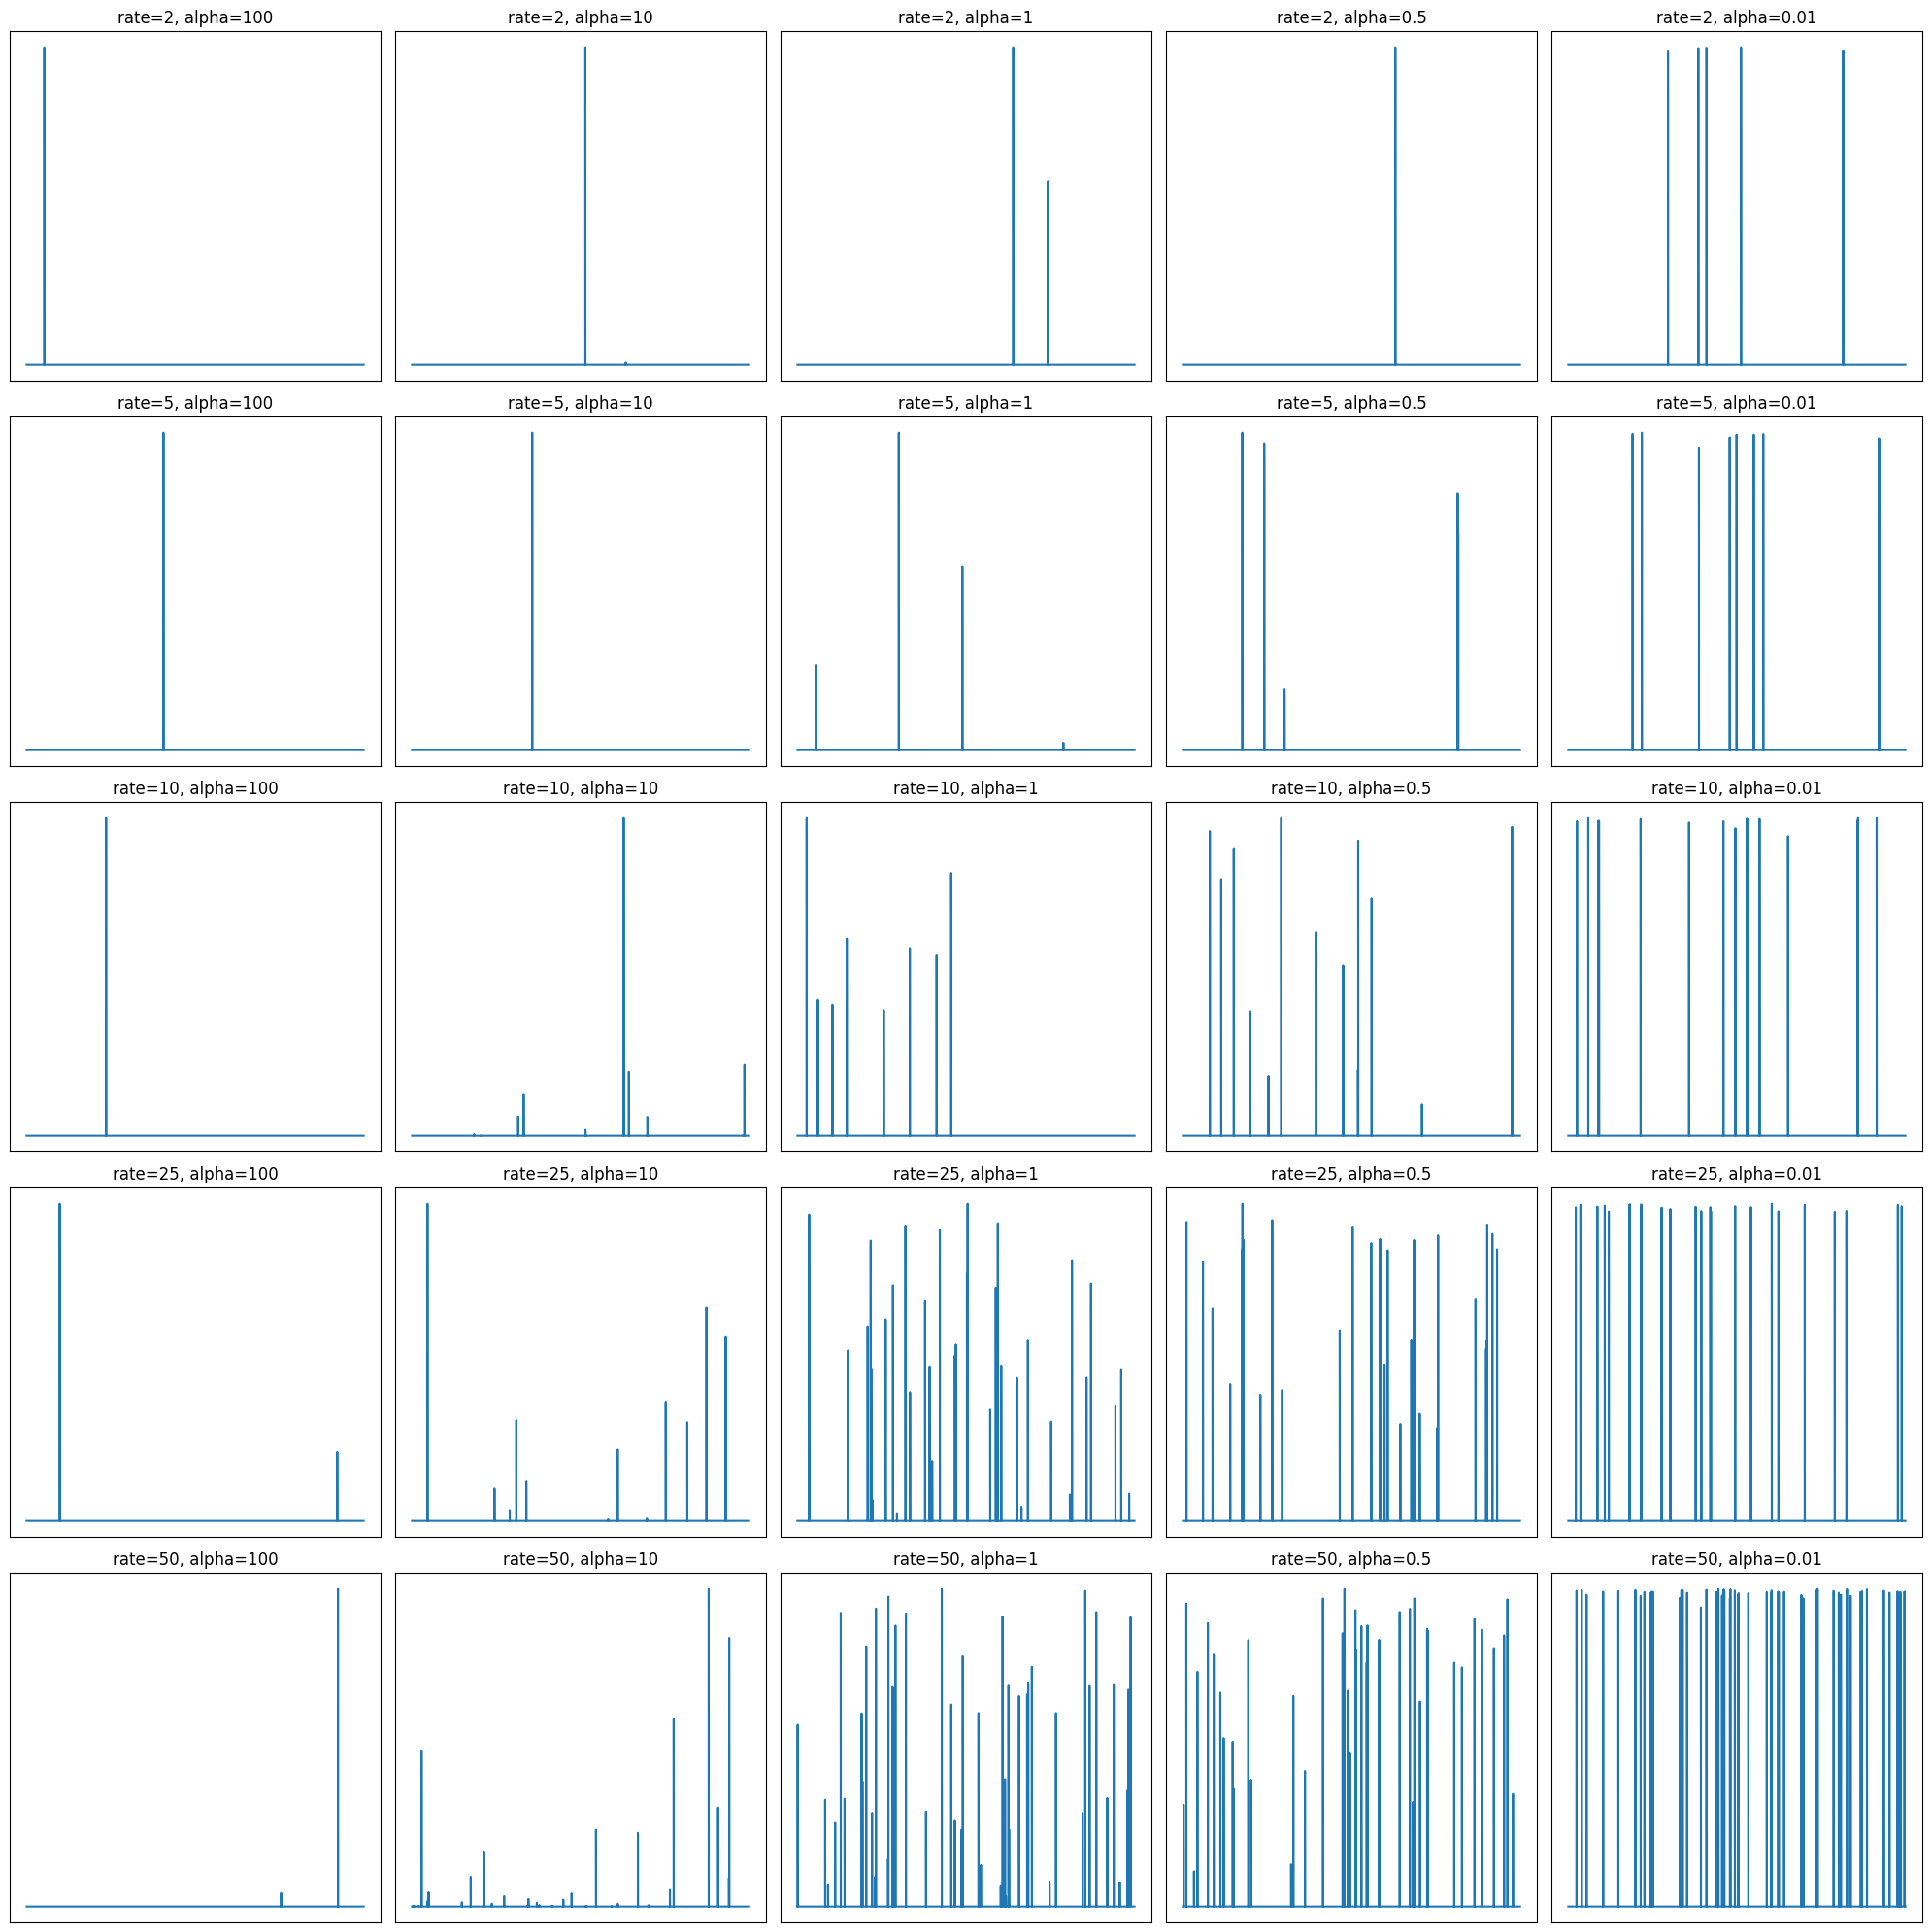

In [4]:
# Provided lists of parameters
rates = [2, 5, 10, 25, 50]
alphas = [100, 10, 1, 0.5, 0.01]

# Provided constants
sr = torch.tensor(44100.)  # standard sr
size = 44100  # 1 second

# Grid size
n_rows = len(rates)
n_cols = len(alphas)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Iterate over all combinations of rates and alphas
for i, (rate, alpha) in enumerate(itertools.product(rates, alphas)):
    row = i // n_cols
    col = i % n_cols

    # Generate the time_stamp tensor
    time_stamp = ts.time_stamps_generator(size, sr, rate, alpha)

    # Plot on the corresponding subplot
    axes[row, col].plot(time_stamp.numpy())
    axes[row, col].set_title(f'rate={rate}, alpha={alpha}')
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Adjust the layout
plt.tight_layout()
plt.show()

### Extra: Density of probability for atoms amplitude.

/tmp/ipykernel_3292649/89941729.py:4: RuntimeWarning: divide by zero encountered in power
  return (1/alpha) * np.power(x,((1-alpha)/alpha))


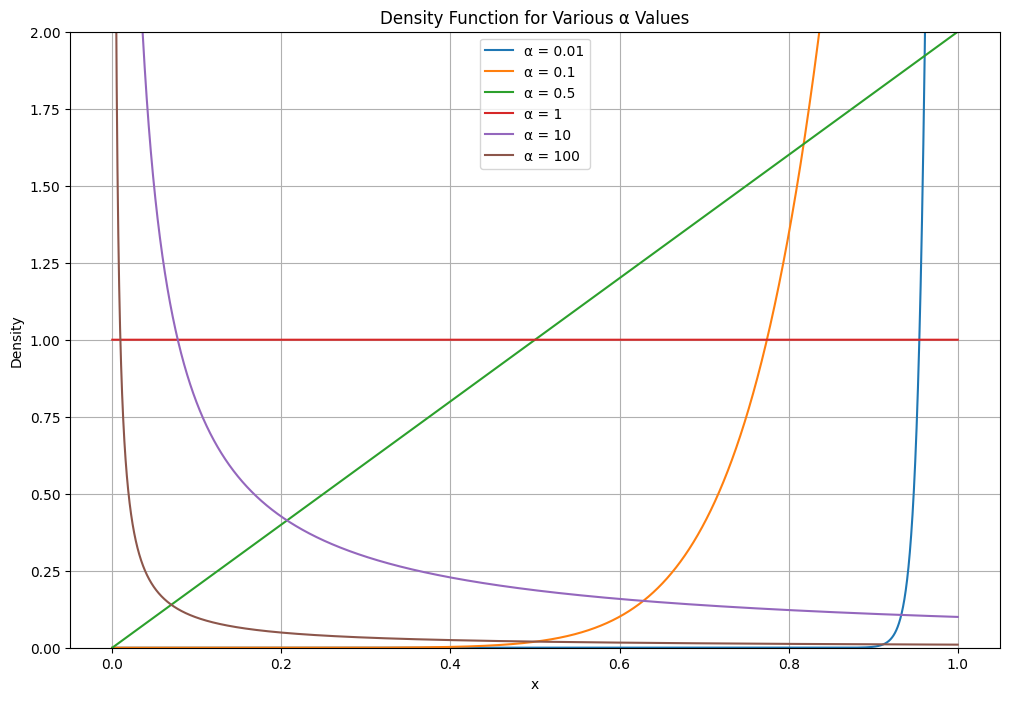

In [5]:
# Distribution of amplitudes 

def density(x, alpha):
    return (1/alpha) * np.power(x,((1-alpha)/alpha))

def riemann_sum(alpha, n=100000000):
    x = np.linspace(0, 1, n+1)
    dx = 1 / n
    y = density(x[:-1] + dx/2, alpha)
    return np.sum(y * dx)    
    

# Values for alpha
alpha_values = [0.01, 0.1, 0.5, 1, 10, 100]

# Plotting the density functions
x = np.linspace(0, 1, 10000)
plt.figure(figsize=(12, 8))

for alpha in alpha_values:
    plt.plot(x, density(x, alpha), label=f'α = {alpha}')

plt.xlabel('x')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.title('Density Function for Various α Values')
plt.legend()
plt.grid(True)
# plt.savefig('density_functions.png')
plt.show()

### Experiment 2: Atom generation through a VAE + the SubEnv Synth

In [6]:
# import modules
from VAE_SubEnv.modules.dataset import *
from VAE_SubEnv.modules.seeds import *
from VAE_SubEnv.modules.architecture import *
from VAE_SubEnv.modules.trainer import *

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

audio_path = '../data/sounds/water_augmented.wav'

frame_size, N_filter_bank, param_per_env = 17640, 24, 512
hidden_size, deepness = 512, 3
latent_dim = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr = 44100
seed = seed_maker(frame_size, sr, N_filter_bank)
seed = seed.to(device)

settings = {
    'frame_size': frame_size,
    'hidden_size': hidden_size,
    'deepness': deepness,
    'latent_dim': latent_dim,
    'N_filter_bank': N_filter_bank,
    'param_per_env': param_per_env,
    }

#Dataset loading
dataset = VAE_Dataset(audio_path, frame_size, sr, N_filter_bank)
dataset_list = dataset.compute_dataset()
print("dataset size: ", len(dataset_list))
dataset.play_dataset(dataset_list, sr)
dataloader = DataLoader(dataset_list, batch_size=16, shuffle=True)

#Model loading
modelo = VAE_SubEnv(hidden_size, deepness, latent_dim, N_filter_bank, param_per_env, seed, device)

#Optimizer
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)

#Training
model_path = '../data/VAE_SubEnv/watermodel/'
train_statistics_loss(modelo, optimizer, 2, device, dataloader, model_path, N_filter_bank, frame_size, sr, settings)

ModuleNotFoundError: No module named 'modules'